#### Importing Requisite packages

In [ ]:
import os, sys, random
import datetime, time, copy
import torch

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import transformers

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import get_linear_schedule_with_warmup
from PIL import Image


In [ ]:
data_folder = "/content/data"

##### Checking if Cuda is available

In [ ]:
use_gpu = torch.cuda.is_available()
print('Using GPU: ', use_gpu)

if use_gpu == True:
	device = torch.device("cuda")
else:
	device = torch.device("cpu")

Using GPU:  True


##### Setting Random Seed

In [ ]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

##### Loading data

In [ ]:
import csv

# Specify the input and output file paths
input_file = "/content/data/train.csv"
output_file = "/content/data/newtrain.csv"
input_file_test = "/content/data/test.csv"
output_file_test = "/content/data/newtest.csv"
# Open the input and output files
with open(input_file, 'r', newline='', encoding='ISO-8859-1') as infile, \
        open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    reader = csv.DictReader(infile)
    fieldnames = ["text", "sentiment"]
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)

    # Write the header to the output file
    writer.writeheader()

    # Iterate through each row in the input file
    for row in reader:
        # Extract text and sentiment from each row
        text = row["text"]
        sentiment = row["sentiment"]

        # Write text and sentiment to the output file
        writer.writerow({"text": text, "sentiment": sentiment})

with open(input_file_test, 'r', newline='', encoding='ISO-8859-1') as infile, \
        open(output_file_test, 'w', newline='', encoding='utf-8') as outfile:
    reader = csv.DictReader(infile)
    fieldnames = ["text", "sentiment"]
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)

    # Write the header to the output file
    writer.writeheader()

    # Iterate through each row in the input file
    for row in reader:
        # Extract text and sentiment from each row
        text = row["text"]
        sentiment = row["sentiment"]

        # Write text and sentiment to the output file
        writer.writerow({"text": text, "sentiment": sentiment})


In [ ]:
import pandas as pd
df=messages = pd.read_csv('/content/data/newtrain.csv', sep=',',
                           names=["text", "sentiment"])
df.head()

,text,sentiment
0,text,sentiment
1,"I`d have responded, if I were going",neutral
2,Sooo SAD I will miss you here in San Diego!!!,negative
3,my boss is bullying me...,negative
4,what interview! leave me alone,negative


In [ ]:
len(df)

27482

In [ ]:
df_test=pd.read_csv('/content/data/newtest.csv', sep=',',
                           names=["text", "sentiment"])
df_test.head()

,text,sentiment
0,text,sentiment
1,Last session of the day http://twitpic.com/67ezh,neutral
2,Shanghai is also really exciting (precisely -...,positive
3,"Recession hit Veronique Branquinho, she has to...",negative
4,happy bday!,positive


In [ ]:
len(df_test)

4816

In [ ]:
df_test = df_test.drop(df_test.index[0])
df = df.drop(df.index[0])


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame with columns 'text' and 'sentiment'
# df = ...

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'sentiment' column
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])
df_test['sentiment_encoded'] = label_encoder.fit_transform(df_test['sentiment'])


In [ ]:
df

,text,sentiment,sentiment_encoded
1,"I`d have responded, if I were going",neutral,1
2,Sooo SAD I will miss you here in San Diego!!!,negative,0
3,my boss is bullying me...,negative,0
4,what interview! leave me alone,negative,0
5,"Sons of ****, why couldn`t they put them on t...",negative,0
...,...,...,...
27477,wish we could come see u on Denver husband l...,negative,0
27478,I`ve wondered about rake to. The client has ...,negative,0
27479,Yay good for both of you. Enjoy the break - y...,positive,2
27480,But it was worth it ****.,positive,2


In [ ]:
df_test

,text,sentiment,sentiment_encoded
1,Last session of the day http://twitpic.com/67ezh,neutral,1
2,Shanghai is also really exciting (precisely -...,positive,2
3,"Recession hit Veronique Branquinho, she has to...",negative,0
4,happy bday!,positive,2
5,http://twitpic.com/4w75p - I like it!!,positive,2
...,...,...,...
4811,NaN,NaN,3
4812,NaN,NaN,3
4813,NaN,NaN,3
4814,NaN,NaN,3


In [ ]:
class_counts = df['sentiment'].value_counts(dropna=False)

# Display the counts
print(class_counts)

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64


In [ ]:
class_counts = df_test['sentiment'].value_counts(dropna=False)

# Display the counts
print(class_counts)

sentiment
neutral     1430
NaN         1281
positive    1103
negative    1001
Name: count, dtype: int64


In [ ]:
df_test = df_test.dropna(subset=['text', 'sentiment'])

In [ ]:
class_counts = df_test['sentiment'].value_counts(dropna=False)

# Display the counts
print(class_counts)

sentiment
neutral     1430
positive    1103
negative    1001
Name: count, dtype: int64


In [ ]:
len(df_test)

3534

In [ ]:
df_shuffled = df.sample(frac=1.0).reset_index(drop=True)

In [ ]:
train_per = 0.75
val_per = 0.25
train_num = int(train_per*len(df_shuffled))
val_num = int(val_per*len(df_shuffled))

In [ ]:
train_num+val_num

27480

In [ ]:
train_df, val_df = df_shuffled[:train_num], df_shuffled[train_num:train_num+val_num]

In [ ]:
train_x, train_y = [train_df.iloc[i]['text'] for i in range(len(train_df))],[train_df.iloc[i]['sentiment_encoded'] for i in range(len(train_df))]
val_x, val_y = [val_df.iloc[i]['text'] for i in range(len(val_df))],[val_df.iloc[i]['sentiment_encoded'] for i in range(len(val_df))]
test_x, test_y = [df_test.iloc[i]['text'] for i in range(len(df_test))],[df_test.iloc[i]['sentiment_encoded'] for i in range(len(df_test))]

##### Loading Bert Model and Tokenizer

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for pos/neu/neg classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# BERT Uncased Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Create an empty list to store the indices of elements that are of float type
float_indices = []

# Iterate through the list and check the type of each element
for i in range(len(val_x)):
    if isinstance(val_x[i], float):
        float_indices.append(i)

# Print the indices of elements that are of float type
print("Indices of elements that are of float type:", float_indices)

Indices of elements that are of float type: [1426]


In [ ]:
del val_x[1426]
del val_y[1426]

##### Looking at distribution of lengths of sentences

In [ ]:
seq_len=[]
for i in range(len(train_x)):
  text_str = str(train_x[i])
  n = len(text_str.split())
  seq_len.append(n)


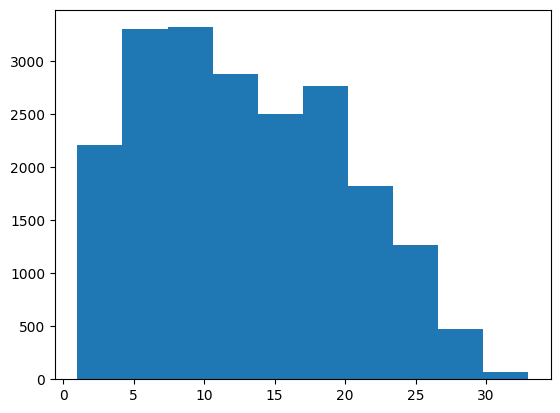

In [ ]:
plt.hist(seq_len)
plt.show()

##### Setting padding length as 30 and tokenizing all text

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_x,
    max_length = 30,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_x,
    max_length = 30,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_x,
    max_length = 30,
    padding='max_length',
    truncation=True
)

##### Converting Sequences, Attention Masks to Tensors

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_y)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_y)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_y)

##### Creating DataLoader objects

In [ ]:
batch_size = 32

# Warping, sampling the training data and creating dataLoader object
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Warping, sampling the validation data and creating dataLoader object
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

##### Printing the Model to look under the hood

In [ ]:
model.to(device)
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

##### The last 'classifier' layer has been intiated with un-trained weights

##### Setting optimizer parameters for training

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


##### Setting scheduler parameters for training

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

##### Defining a helper function

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

##### Training

In [ ]:
# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear Gradients
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch)
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        loss, logits = output.loss, output.logits

        # Accumulate the training loss over all of the batches
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            output = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

            loss, logits = output.loss, output.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch   100  of    645.    Elapsed: 0:00:18.
  Batch   200  of    645.    Elapsed: 0:00:35.
  Batch   300  of    645.    Elapsed: 0:00:53.
  Batch   400  of    645.    Elapsed: 0:01:10.
  Batch   500  of    645.    Elapsed: 0:01:28.
  Batch   600  of    645.    Elapsed: 0:01:46.

  Average training loss: 0.62
  Training epcoh took: 0:01:55

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.55
  Validation took: 0:00:11

======== Epoch 2 / 4 ========
Training...
  Batch   100  of    645.    Elapsed: 0:00:18.
  Batch   200  of    645.    Elapsed: 0:00:36.
  Batch   300  of    645.    Elapsed: 0:00:54.
  Batch   400  of    645.    Elapsed: 0:01:12.
  Batch   500  of    645.    Elapsed: 0:01:30.
  Batch   600  of    645.    Elapsed: 0:01:48.

  Average training loss: 0.41
  Training epcoh took: 0:01:56

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.59
  Validation took: 0:00:11

======== Epoch 3 / 4 ========
Training...
 

In [ ]:
trained_model = copy.deepcopy(model)
torch.save(trained_model,'/content/models/fine_tuned_bert_model' + '.t7')

#####Prediction on test dataset

In [ ]:
with torch.no_grad():
  preds = trained_model(test_seq.to(device), test_mask.to(device))
  #preds = preds.detach().cpu().numpy()

In [ ]:
logits_tensor = preds.logits

# Convert logits tensor to numpy array
logits_numpy = logits_tensor.cpu().numpy()

#####Classification report

In [ ]:
preds = np.argmax(logits_numpy, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1001
           1       0.72      0.74      0.73      1430
           2       0.82      0.80      0.81      1103

    accuracy                           0.77      3534
   macro avg       0.77      0.77      0.77      3534
weighted avg       0.77      0.77      0.77      3534

